In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [61]:
#Импортируем спаршенные данные
df = pd.read_excel(r"aktsii.xlsx")
df

,TICKER,ЦЕНА,КОЛИЧЕСТВО АКЦИЙ,ПРИБЫЛЬ,ВЫРУЧКА,FCF,Собственный капитал (EQUITY),АКТИВЫ 2021,АКТИВЫ 2022,ROA,Балансовая стоиомтсь,Размер,Чистые активы,CEO's gender,CEO's age,CEO's education,CEO's qual
0,CIAN,595.20,69042400,480000000,8266000000,1802000000,5009000000,5600000000,6974000000,0.076348,5009000000,0.199181,5009000000,1,1,0,1
1,ETLN,79.98,383441416,13001000000,80556000000,-52016000000,74189000000,222098000000,248045000000,0.055307,74189000000,0.078900,74189000000,0,1,1,0
2,FIXP,295.50,850000000,21411000000,277644000000,24767000000,29267000000,84929000000,113026000000,0.216322,29267000000,0.073923,29267000000,0,1,0,1
3,GLTR,615.40,178740916,24919886000,94474032000,28752204000,67462195000,108284996000,110154102000,0.228163,67462195000,0.154419,67462195000,1,0,1,0
4,HHRU,2973.00,50635720,3691494000,18085164000,7219260000,6863685000,22782272000,23900880000,0.158151,6863685000,0.073514,6863685000,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,MAGE,4.45,145673254,-2561000000,11923000000,-2966000000,3484000000,14070000000,18478000000,-0.157368,3484000000,0.053521,3484000000,1,0,0,0
108,SAGO,3.15,3538928532,1122014000,40754572000,1227829000,6380626000,9205918000,10285896000,0.115127,6380626000,0.163675,6380626000,1,0,0,0
109,SAGO,3.15,521993080,1122014000,40754572000,1227829000,6380626000,9205918000,10285896000,0.115127,6380626000,0.163675,6380626000,0,1,0,1
110,SLEN,4.96,1237175444,-6295000000,12475000000,-3245000000,11461000000,38654000000,28941000000,-0.186256,11461000000,0.084777,11461000000,0,0,0,0


<Axes: xlabel='FCF', ylabel='Count'>

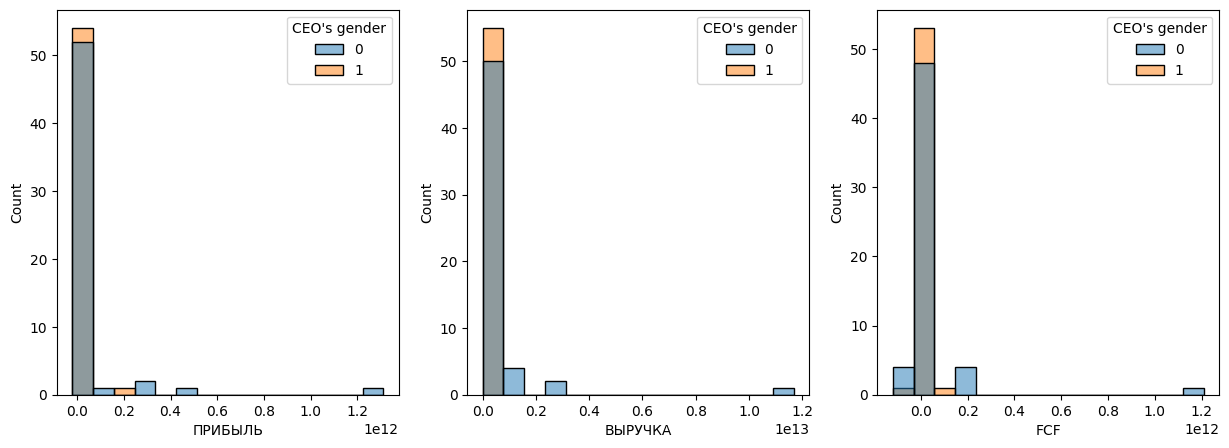

In [184]:
f, axes = plt.subplots(1, 3, figsize=(15, 5))


sns.histplot(df, x = "ПРИБЫЛЬ", bins=15, hue= """CEO's gender""", ax=axes[0])
sns.histplot(df, x = "ВЫРУЧКА", bins=15, hue= """CEO's gender""",  ax=axes[1])
sns.histplot(df, x = "FCF", bins=15, hue= """CEO's gender""", ax=axes[2])